# Teaching notebok for total imaging newbies
https://www.kaggle.com/stkbailey/teaching-notebook-for-total-imaging-newbies

이 커널은 고전적인 이미지 기술을 구현하고 이미지 데이터로 작업한 적 없는 사람들에게 유용합니다. 궁극적으로, 우리는 테스트 이미지에 적용할 수 있는 scipy, numpy, scikit-image을 사용하여 간단한 파이프라인을 개발할 것입니다. 사실, 우리는 매개 변수를 최적화하는 것 외에는 훈련 이미지조차 사용하지 않을 것입니다.

In [1]:
import pathlib
import imageio
import numpy as np

training_paths = pathlib.Path('./input/stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[45]
im = imageio.imread(str(im_path))

## Dealing with color
이 데이터 세트의 영상은 RGB, RGBA 및 그레이 스케일 형식으로 획득할 수 있습니다. 컬러 영상의 경우 '채널'(예:빨간색, 녹색, 파란색)을 인코딩하는 3차원입니다. 첫 번째 패스를 간단히 하기 위해, 우리는 scikit-image의 rgb2gray 함수를 사용하여 모든 이미지를 그레이 스케일로 바꿀 수 있습니다.

In [2]:
# 이미지 차원 출력
print('Original image shape: {}'.format(im.shape))

# 이미지를 그레이 스케일 형식으로 강제 적용
from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

Original image shape: (520, 696, 4)
New image shape: (520, 696)


C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  


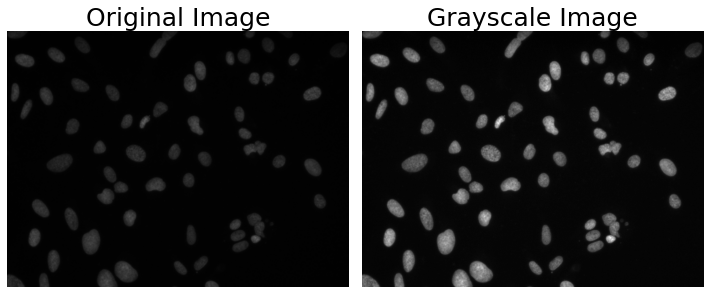

In [8]:
# Plot data
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()

## 배경 제거
이 문제에 대한 가장 간단한 접근 방식은 이미지에 객체와 배경의 두 가지 클래스가 있다고 가정하는 것입니다. 이러한 가정 하에, 우리는 데이터가 두 가지 강도의 모달 분포에 속할 것으로 예상합니다. 최상의 분리 값을 찾으면 배경 데이터를 '마스킹'한 다음 남은 개체를 셀 수 있습니다.

임계값을 찾을 수 있는 가장 '무식한' 방법은 평균 또는 중위수와 같은 간단한 기술 통계량을 사용하는 것입니다. 그러나 다른 방법들도 있습니다. 'Otsu' 방법은 이미지를 바이모달 분포로 모델링하고 최적의 분리 값을 찾습니다.

In [3]:
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(im_gray)
mask = np.where(im_gray > thresh_val, 1, 0)

# 마스크의 큰 부분이 배경인지 확인
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

Text(0.5, 1.0, 'Image w/mask')

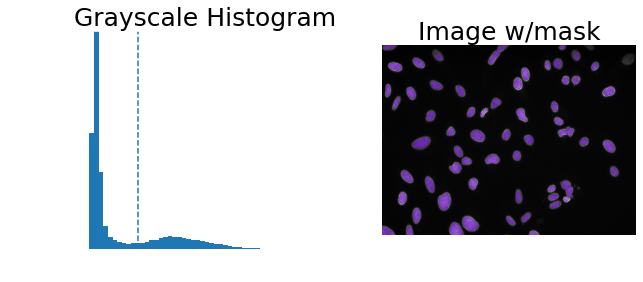

In [9]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
im_pixels = im_gray.flatten()
plt.hist(im_pixels, bins=50)
plt.vlines(thresh_val, 0, 100000, linestyle='--')
plt.ylim([0, 50000])
plt.title('Grayscale Histogram')

plt.subplot(1, 2, 2)
mask_for_display = np.where(mask, mask, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/mask')

## 각 개체에 대한 마스크 가져오기
이 대회를 위해 각각의 핵에 대해 별도의 마스크를 얻어야 합니다. 이 작업을 수행할 수 있는 한 가지 방법은 마스크에서 연결된 모든 개체를 찾고 ndimage.label을 사용하여 각 개체를 할당하는 것입니다. 그런 다음 label_id를 순환하여 리스트와 같은 반복자에 추가할 수 있습니다.

In [7]:
from scipy import ndimage
labels, nlabels = ndimage.label(mask)

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)
    
print('There are {} seperate components / objects detected.'.format(nlabels))

There are 76 seperate components / objects detected.


Text(0.5, 1.0, 'Labeled Cells (76 Nuclei)')

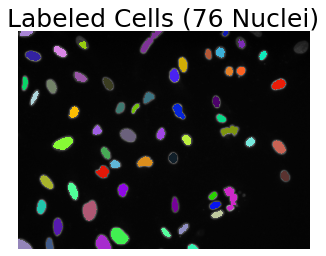

In [10]:
# Create random colormap
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256, 3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))

간단한 이미지를 통해 다음 두 가지 문제를 확인할 수 있습니다.
- 몇 개의 개별 픽셀이 있습니다.(예: 오른쪽 상단)
- 일부 셀은 단일 마스크(예: 상단 중간)로 결합됩니다.

`ndimage.find_objects`를 사용하여 마스크를 통해 개별 핵을 확대하여 추가적인 처리 단계를 적용하는 것을 반복할 수 있습니다. `find_contract`는 이미지에서 각 레이블링된 객체에 대한 좌표 범위 목록을 반환합니다.

In [11]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]
    
    # 라벨 사이즈가 너무 작은지 확인
    if np.product(cell.shape) < 10:
        print('Label {} is too small! Setting to 0'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask)
        
# 라벨 재생산
labels, nlabels = ndimage.label(mask)
print('There are now {} seperate components / objects detected.'.format(nlabels))

Label 4 is too small! Setting to 0
Label 5 is too small! Setting to 0
Label 7 is too small! Setting to 0
Label 8 is too small! Setting to 0
Label 9 is too small! Setting to 0
Label 10 is too small! Setting to 0
Label 14 is too small! Setting to 0
Label 15 is too small! Setting to 0
Label 16 is too small! Setting to 0
Label 19 is too small! Setting to 0
Label 21 is too small! Setting to 0
Label 22 is too small! Setting to 0
Label 23 is too small! Setting to 0
Label 60 is too small! Setting to 0
Label 61 is too small! Setting to 0
Label 72 is too small! Setting to 0
There are now 60 seperate components / objects detected.


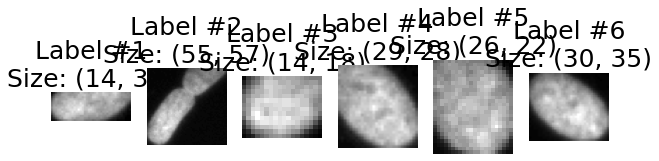

In [13]:
fig, axes = plt.subplots(1, 6, figsize=(10, 6))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[0:6]):
    cell = im_gray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))
    
plt.show()

label #2에는 '인접 셀' 문제가 있습니다. 두 셀은 동일한 객체의 일부로 간주되고 있습니다. 여기서 우리가 할 수 있는 한 가지는 우리가 세포들 사이의 차이를 '열기'위해 마스크를 축소할 수 있는지 확인하는 것입니다. 이것을 마스크 침식이라고 합니다. 그런 다음 원래 비율을 복구하기 위해 다시 희석할 수 있습니다.

In [14]:
# 객체 인덱스를 가져오고 바이너리 오프닝 절차 수행
two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = mask[two_cell_indices]
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=8)

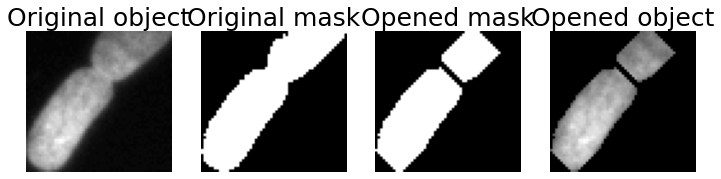

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

axes[0].imshow(im_gray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')
axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')
axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(im_gray[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')

for ax in axes:
    ax.axis('off')

## 레이블이 지정된 각 개체를 Run Line Enconding으로 변환
마지막으로 각 label_mask를 'run line encoded'문자열로 인코딩해야 합니다. 기본적으로 배열을 통해 마스크의 일부인 픽셀을 찾으면 이를 인덱싱하고 마스크의 일부인 후속 픽셀 수를 계산합니다. 우리는 새로운 픽셀 시작점을 볼 때마다 이것을 반복합니다.

In [18]:
def rle_encoding(x):
    dots = np.where(x.T.flatten()==1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask is: 210075 6 210593 8 211112 9 211631 10 212150 11 212669 12 213189 12 213709 12 214228 13 214748 13 215268 13 215788 13 216308 13 216828 13 217348 13 217869 12 218389 12 218909 12 219430 11 219950 11 220471 10 220991 10 221512 9 222033 8 222554 7 223075 6 223596 5 224117 4 224639 2


## 단일 함수로 결합
이제 우리는 이미지를 처리하는 기본 단계를 보았기 때문에 하나로 결합할 수 있습니다. 이 함수는 이미지 경로를 선택하고 위에서 설명한 프로세스를 수행한 다음 발견된 각 마스크에 대해 RLE 문자열이 있는 데이터 프레임을 표시합니다.

또한 데이터 세트의 모든 이미지에 대해 단일 데이터프레임을 발산하는 래퍼 함수도 생성합니다.

In [20]:
import pandas as pd

def analyze_image(im_path):
    # 데이터 로드 후 그레이 스케일 변환
    im_id = im_path.parts[-3]
    im = imageio.imread(str(im_path))
    im_gray = rgb2gray(im)
    
    # 배경을 마스킹하고 연결된 객체 추출
    thresh_val = threshold_otsu(im_gray)
    mask = np.where(im_gray > thresh_val, 1, 0)
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # 라벨 루프문을 통해 데이터프레임에 추가
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
            
    return im_df

def analyze_list_of_images(im_path_list):
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
        
    return all_df

In [21]:
testing = pathlib.Path('/input/stage1_test').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submission.csv', index=None)